# VIX Forecasting and Tactical Volatility-Driven Equity Strategy

## Project Objective

This project investigates whether market volatility, as measured by the VIX, can be predicted using a combination of macro-financial indicators and technical features. The goal is to use next-day VIX movement forecasts to dynamically adjust exposure to the equity market (via the S&P 500, though other equities are available), thereby constructing a simple rules-based macro trading strategy.

The underlying hypothesis is that spikes in volatility often precede equity drawdowns, and that anticipating these shifts can improve risk-adjusted returns compared to passive long-only exposure.

---

## Data & Instruments

Data is sourced using `yfinance` and spans approximately 20 years of daily prices. The following instruments and indices are used:

- **VIX (`^VIX`)** — CBOE Volatility Index (implied volatility of S&P 500)
- **VVIX (`^VVIX`)** — Volatility-of-Volatility Index (implied volatility of the VIX itself)
- **SPY (`SPY`)** — S&P 500 ETF (proxy for US equity exposure)
- **SH (`SH`)** — ProShares Short S&P 500 ETF (inverse exposure to SPY)
- **10-Year Treasury Yield (`^TNX`)** — Proxy for macroeconomic sentiment and interest rate expectations

---

## Methodology

1. **Feature Engineering**  
   - Daily returns for VIX, SPY, SH, and TNX  
   - VIX-to-SMA ratio and rolling standard deviation  
   - VIX–VVIX spread to capture divergence in volatility expectations  

2. **Model Training**  
   - Binary classification task: whether VIX will rise the next day  
   - Logistic Regression model trained on historical data (no shuffle)  
   - Evaluated on accuracy, precision, recall, F1-score  

3. **Strategy Construction**  
   - Use model output probabilities to adjust SPY exposure (long SPY or long SH)  
   - Calibrate the decision threshold based on historical return optimization  
   - Backtest cumulative performance and benchmark against SPY Buy & Hold  

4. **Performance Evaluation**  
   - Total and annualized returns  
   - Sharpe ratio (risk-adjusted return)  
   - Maximum drawdown  
   - Comparison to passive benchmark  

---

## Key Deliverables

- Fully functional Python pipeline: data ingestion → feature generation → model training → strategy backtest  
- Visualizations: classification metrics, confusion matrix, threshold calibration, strategy vs SPY performance  
- Model interpretability: logistic regression coefficient analysis  
- Backtest aligned with annotated macro events (e.g., Fed hikes, inflation shocks, geopolitical risks)

---

## Context

Developed as part of an independent project combining financial economics, machine learning, and political risk. Intended to demonstrate how volatility expectations can be operationalized into systematic equity allocation strategies under uncertainty. With a view towards building ability to forecast price action, building essential skills for a career in global markets.



# Housekeeping

In [168]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Data Gathering, Generating Features

In [169]:

def get_data():
    Vol_Index = yf.download("^VIX", auto_adjust=True, period='20y')["Close"]
    SPY = yf.download("SPY", auto_adjust=True, period='20y')["Close"]
    SH = yf.download("SH", auto_adjust=True, period='20y')["Close"]
    VolVol_Index = yf.download("^VVIX", auto_adjust=True, period='20y')["Close"]
    TenYearTNote = yf.download("^TNX", auto_adjust=True, period='20y')["Close"]

    df = pd.concat([Vol_Index, SPY, SH, VolVol_Index, TenYearTNote], axis=1)
    df.columns = ['Vol_Index', 'SPY', 'SH', 'VolVol_Index', 'TenYearTNote']
    return df.dropna()


def get_features(df):
    # Daily Returns
    df['VIX_ret_1d'] = df['Vol_Index'].pct_change()
    df['SPY_ret_1d'] = df['SPY'].pct_change()
    df['SH_ret_1d'] = df['SH'].pct_change()  # Add SH return

    # Technical Indicators for VIX
    df['VIX_SMA20'] = df['Vol_Index'].rolling(20).mean() #Indicates if VIX is elevated or depressed
    df['VIX_ratio'] = df['Vol_Index'] / df['VIX_SMA20'] #Suggests that VIX might be high compared to recent history if greater than 1 
    df['VIX_std20'] = df['Vol_Index'].rolling(20).std() #Measures the volatility of its volatility, higher values might imply whether VIX is unstable or erratic

    # Spread Features
    df['VIX_VVIX_spread'] = df['Vol_Index'] - df['VolVol_Index']  #Spread between VIX and VVIX, larger spread often precedes spikes in market fear
    df['TNX_ret_1d'] = df['TenYearTNote'].pct_change()  #10yr treasury yield return - Captures Macro Sentiment 

    # Will VIX Rise Tomorrow?
    df['VIX_direction'] = (df['Vol_Index'].shift(-1) > df['Vol_Index']).astype(int) #Predicting whether VIX will increase using above features

    return df.dropna()

# Train/Test Split, Training the Model, and Evaluating

In [170]:
def get_features_train_test_split(df):
    features = ['VIX_ret_1d', 'SPY_ret_1d', 'VIX_ratio', 'VIX_std20', 'VIX_VVIX_spread', 'TNX_ret_1d']
    input_data = df[features].dropna()
    target_variable = df.loc[input_data.index, 'VIX_direction']

    X_train, X_test, y_train, y_test = train_test_split(input_data, target_variable, train_size=0.8, shuffle=False)
    return X_train, X_test, y_train, y_test

def train_model(X_train, y_train):
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    return model


def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    return y_pred, y_proba

# Summarising Performance 

In [171]:
def model_performance_summary(y_test, y_pred):
    report = classification_report(y_test, y_pred, output_dict=True)

    print("=== Model Classification Report ===")
    print(classification_report(y_test, y_pred))
    print(f"• Overall accuracy: {report['accuracy']:.2%}\n")

    for cls in ['0', '1']:
        precision = report[cls]['precision']
        recall = report[cls]['recall']
        f1 = report[cls]['f1-score']
        support = report[cls]['support']

        if cls == '0':
            print("• Class '0' (VIX does NOT rise next day):")
        else:
            print("• Class '1' (VIX RISES next day):")

        print(f"  - Precision: {precision:.2%} (Correctness of predictions)")
        print(f"  - Recall: {recall:.2%} (How many actual cases identified)")
        print(f"  - F1-score: {f1:.2%} (Balance of precision & recall)")
        print(f"  - Sample count: {support}\n")

# Visualising Model Metrics

In [172]:
def plot_classification_report(y_test, y_pred):
    from sklearn.metrics import classification_report
    report = classification_report(y_test, y_pred, output_dict=True)
    classes = ['0', '1']
    
    headers = ["Class", "Precision", "Recall", "F1-Score", "Support"]
    rows = []
    for cls in classes:
        rows.append([
            f"Class {cls}",
            f"{report[cls]['precision']:.2%}",
            f"{report[cls]['recall']:.2%}",
            f"{report[cls]['f1-score']:.2%}",
            f"{int(report[cls]['support'])}"
        ])

    fig, ax = plt.subplots(figsize=(6, 2))
    ax.axis('tight')
    ax.axis('off')
    table_data = [headers] + rows
    table = ax.table(cellText=table_data, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    plt.title("Classification Report Summary")
    plt.show()



def plot_confusion_matrix(y_test, y_pred):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    labels = ['Predicted 0', 'Predicted 1']

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Normalized Confusion Matrix (Row-wise)")
    plt.show()

# Calibrating to Find the Optimal Strategy

In [173]:
def find_best_threshold(df, X_test, y_proba):
    df = df.copy()
    df['SPY_ret_1d'] = df['SPY'].pct_change()
    thresholds = np.arange(0.3, 0.6, 0.025)
    returns = []

    for t in thresholds:
        df['position'] = 0
        df.loc[X_test.index, 'position'] = np.where(y_proba > t, 1, -1)
        df['strategy_ret'] = df['position'].shift(1) * df['SPY_ret_1d']
        cumulative = (1 + df['strategy_ret']).cumprod()
        returns.append(cumulative.dropna().iloc[-1])

    plt.figure(figsize=(10, 2))
    sns.heatmap([returns], xticklabels=[f"{th:.3f}" for th in thresholds], cmap="RdYlGn", annot=True, fmt=".4f")
    plt.title("Strategy Final Returns by Threshold")
    plt.xlabel("Threshold")
    plt.yticks([], [])
    plt.show()

    best_idx = np.argmax(returns)
    best_threshold = thresholds[best_idx]
    print(f"Best threshold found: {best_threshold:.3f} with final return {returns[best_idx]:.4f}\n")
    return best_threshold


# Backtesting the Strategy

In [174]:
def backtest_strategy(df, X_test, y_proba, threshold):
    df = df.copy()
    df['SPY_ret'] = df['SPY'].pct_change()
    start_date = X_test.index[0]
    df = df.loc[start_date:]

    df['position'] = 0
    df.loc[X_test.index, 'position'] = np.where(y_proba > threshold, 1, -1)

    df['strategy_ret'] = df['position'].shift(1) * df['SPY_ret']
    df['cumulative_strategy'] = (1 + df['strategy_ret']).cumprod()
    df['cumulative_spy'] = (1 + df['SPY_ret']).cumprod()
    return df

def plot_backtest_results(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['cumulative_strategy'], label='Strategy', color='dodgerblue', linewidth=2)
    plt.plot(df.index, df['cumulative_spy'], label='SPY (Buy & Hold)', color='orange', linewidth=2)

    macro_events = {
        "2022-01-24": "Tech Drawdown",
        "2022-03-16": "1st Fed Hike",
        "2022-06-13": "CPI Shock",
        "2022-09-21": "Dot Plot Surprise",
        "2022-10-13": "CPI Reversal",
        "2023-03-10": "SVB Collapse",
        "2023-10-19": "10Y @ 5%",
        "2024-03-20": "No Rate Cut",
        "2024-07-05": "NFP Beat",
        "2024-11-05": "Election Volatility",
        "2025-02-01": "China Crash",
        "2025-04-07": "Tariff Bear Market",
        "2025-07-21": "Profit Shock Report"
    }

    ymax = max(df['cumulative_strategy'].max(), df['cumulative_spy'].max())
    ymin = min(df['cumulative_strategy'].min(), df['cumulative_spy'].min())
    yrange = ymax - ymin

    for date_str, label in macro_events.items():
        date = pd.to_datetime(date_str)
        if date in df.index:
            plt.axvline(x=date, color='black', linestyle='dotted', linewidth=1)
            xpos = date
            ypos = ymax - 0.05 * yrange  # place label inside chart

            # Align text based on left/right side of chart
            align = 'right' if xpos > df.index.mean() else 'left'
            plt.text(
                xpos, ypos, label,
                rotation=90,
                verticalalignment='top',
                horizontalalignment=align,
                fontsize=9,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
            )

    plt.title("Cumulative Returns: Macro Strategy vs SPY")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Summarising Strategy Performance

In [175]:
def strategy_performance_summary(df):
    cumulative_return = df['cumulative_strategy'].iloc[-1] - 1
    total_days = len(df.dropna())
    annual_factor = 252

    annualized_return = (df['cumulative_strategy'].iloc[-1]) ** (annual_factor / total_days) - 1
    strat_ret = df['strategy_ret'].dropna()
    sharpe_ratio = strat_ret.mean() / strat_ret.std() * np.sqrt(annual_factor)

    running_max = df['cumulative_strategy'].cummax()
    drawdown = (df['cumulative_strategy'] - running_max) / running_max
    max_drawdown = drawdown.min()

    spy_return = df['cumulative_spy'].iloc[-1] - 1
    spy_cagr = df['cumulative_spy'].iloc[-1] ** (annual_factor / total_days) - 1
    spy_ret = df['SPY'].pct_change()
    spy_sharpe = spy_ret.mean() / spy_ret.std() * np.sqrt(annual_factor)

    spy_running_max = df['cumulative_spy'].cummax()
    spy_drawdown = (df['cumulative_spy'] - spy_running_max) / spy_running_max
    spy_max_drawdown = spy_drawdown.min()

    print("=== Strategy Performance Summary ===")
    print(f"Total Return: {cumulative_return*100:.2f}%")
    print(f"Annualized Return (CAGR): {annualized_return*100:.2f}%")
    print(f"Sharpe Ratio (annualized): {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown*100:.2f}%\n")
    print(f"SPY Total Return (Buy & Hold): {spy_return*100:.2f}%")
    print(f"SPY Annualized Return (CAGR): {spy_cagr*100:.2f}%")
    print(f"SPY Sharpe Ratio (annualized): {spy_sharpe:.2f}")
    print(f"SPY Max Drawdown: {spy_max_drawdown*100:.2f}%")

def plot_feature_importance_logreg(model, feature_names):
    coefs = model.coef_[0]
    df_imp = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coefs
    }).sort_values(by="Coefficient")
    
    colors = ['blue' if x > 0 else 'red' for x in df_imp['Coefficient']]

    plt.figure(figsize=(8, max(4, 0.3 * len(df_imp))))
    plt.barh(df_imp['Feature'], df_imp['Coefficient'], color=colors)
    plt.xlabel("Coefficient Value")
    plt.title("Feature Importance (Logistic Regression Coefficients)")
    plt.tight_layout()
    plt.show()

# Executing the Code

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

=== Model Classification Report ===
              precision    recall  f1-score   support

           0       0.57      0.91      0.70       528
           1       0.47      0.11      0.18       400

    accuracy                           0.56       928
   macro avg       0.52      0.51      0.44       928
weighted avg       0.53      0.56      0.48       928

• Overall accuracy: 56.36%

• Class '0' (VIX does NOT rise next day):
  - Precision: 57.37% (Correctness of predictions)
  - Recall: 90.72% (How many actual cases identified)
  - F1-score: 70.29% (Balance of precision & recall)
  - Sample count: 528.0

• Class '1' (VIX RISES next day):
  - Precision: 47.31% (Correctness of predictions)
  - Recall: 11.00% (How many actual cases identified)
  - F1-score: 17.85% (Balance of precision & recall)
  - Sample count: 400.0



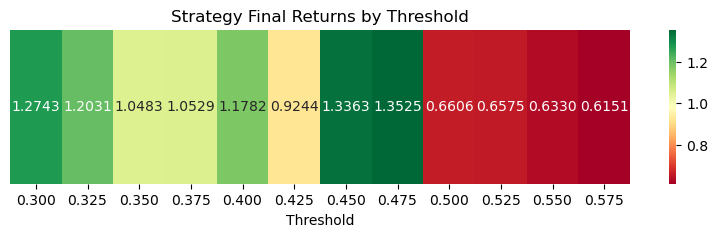

Best threshold found: 0.475 with final return 1.3525



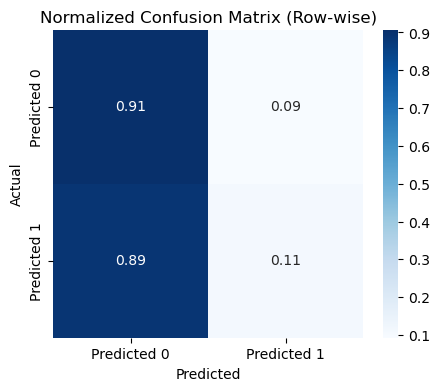

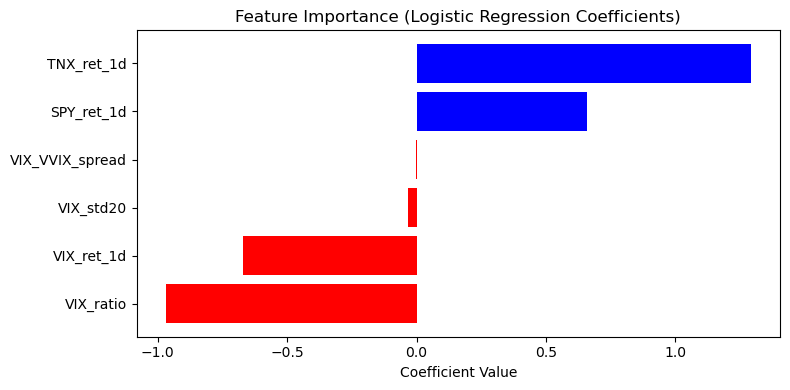

=== Strategy Performance Summary ===
Total Return: 35.25%
Annualized Return (CAGR): 8.56%
Sharpe Ratio (annualized): 0.53
Max Drawdown: -16.57%

SPY Total Return (Buy & Hold): 42.66%
SPY Annualized Return (CAGR): 10.14%
SPY Sharpe Ratio (annualized): 0.62
SPY Max Drawdown: -24.50%


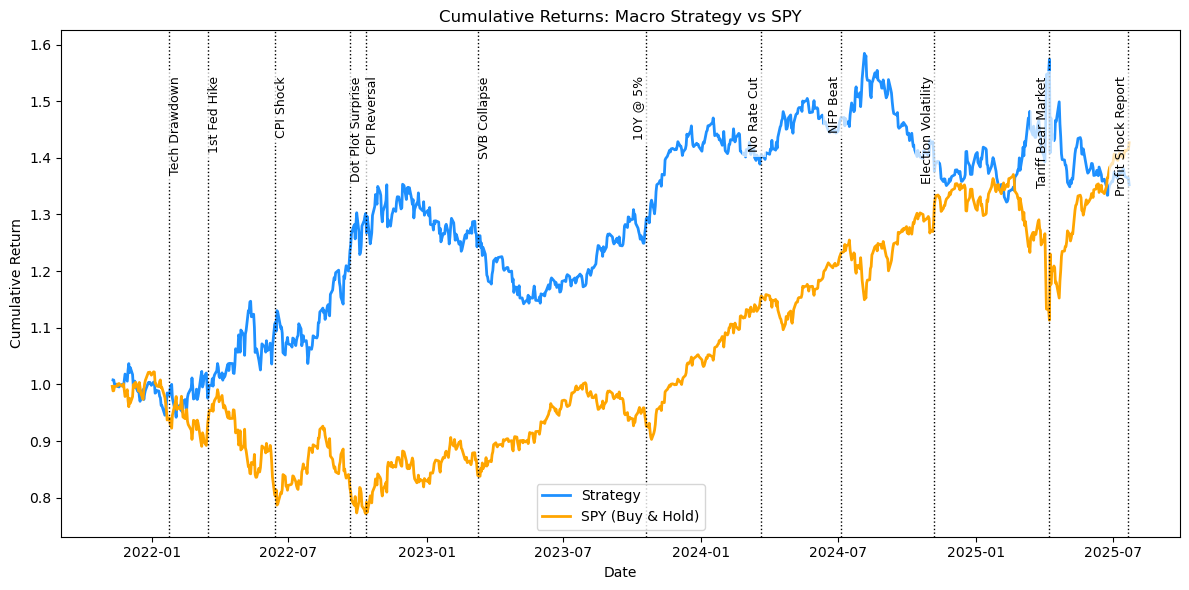

In [176]:
def main():
    df = get_data()
    df = get_features(df)

    X_train, X_test, y_train, y_test = get_features_train_test_split(df)
    feature_names = X_train.columns.tolist()
    model = train_model(X_train, y_train)
    y_pred, y_proba = evaluate_model(model, X_test, y_test)

    model_performance_summary(y_test, y_pred)
    best_threshold = find_best_threshold(df, X_test, y_proba)

    plot_confusion_matrix(y_test, y_pred)
    plot_feature_importance_logreg(model, feature_names)

    backtest_df = backtest_strategy(df, X_test, y_proba, best_threshold)
    strategy_performance_summary(backtest_df)
    plot_backtest_results(backtest_df)

main()